In [158]:
import pandas as pd
import requests
import io

CH_HOST = 'http://localhost:8123'
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

def get_clickhouse_data(query, host = CH_HOST, connection_timeout = 1500):
    r = requests.post(host, params = {'query': query}, timeout = connection_timeout)
    if r.status_code == 200:
        return r.text
    else:
        raise ValueError(r.text)
        
def get_clickhouse_df(query, host = CH_HOST, connection_timeout = 1500):
    data = get_clickhouse_data(query, host, connection_timeout) 
    df = pd.read_csv(io.StringIO(data), sep = '\t')
    return df

def upload(table, content, host=CH_HOST):
    content = content.encode('utf-8')
    query_dict = {
             'query': 'INSERT INTO ' + table + ' FORMAT TabSeparatedWithNames '
        }
    r = requests.post(host, data=content, params=query_dict)
    result = r.text
    if r.status_code == 200:
        return result
    else:
        raise ValueError(r.text)

In [159]:
q = '''
select
    VisitID,
    StartDate,
    UTCStartTime,
    Duration,
    StartURLDomain,
    IsMobile,
    UserAgent,
    OS
from datasets.visits_v1 final
limit 10
format TabSeparatedWithNames
'''

tmp_df = get_clickhouse_df(q)

In [160]:
tmp_df

,VisitID,StartDate,UTCStartTime,Duration,StartURLDomain,IsMobile,UserAgent,OS
0,6949594573706600954,2014-03-17,2014-03-17 11:38:42,0,gruzomoy.sumtel.com.ua,0,7,2
1,7763399689682887827,2014-03-17,2014-03-17 18:22:20,24,gruzomoy.sumtel.com.ua,0,2,2
2,9153706821504089082,2014-03-17,2014-03-17 09:41:09,415,gruzomoy.sumtel.com.ua,0,7,35
3,5747643029332244007,2014-03-17,2014-03-17 04:46:08,19,gruzomoy.sumtel.com.ua,0,2,238
4,5868920473837897470,2014-03-17,2014-03-17 10:10:31,11,gruzomoy.sumtel.com.ua,0,3,35
5,6587050697748196290,2014-03-17,2014-03-17 09:06:47,18,gruzomoy.sumtel.com.ua,0,120,35
6,8872348705743297525,2014-03-17,2014-03-17 06:40:43,190,gruzomoy.sumtel.com.ua,0,5,238
7,8890846394730359529,2014-03-17,2014-03-17 02:27:19,0,gruzomoy.sumtel.com.ua,0,57,35
8,7429587367586011403,2014-03-17,2014-03-17 01:13:14,0,gruzomoy.sumtel.com.ua,1,1,12
9,5195928066127503662,2014-03-17,2014-03-17 01:43:02,1926,gruzomoy.sumtel.com.ua,0,2,35


In [161]:
import numpy as np  
prev = np.array([0.7, 0.2, 0.1])
curr = np.array([0.6, 0.27, 0.13])

def get_kl_divergence(prev, curr):
    kl = prev * np.log(prev / curr)
    return np.sum(kl)

def get_js_divergence(prev, curr): 
    mean = (prev + curr)/2
    return 0.5*(get_kl_divergence(prev, mean) + get_kl_divergence(curr, mean))

def get_l1(prev, curr):
    return np.abs(prev - curr).sum()/2

kl = get_kl_divergence(prev, curr)
js = get_js_divergence(prev, curr)

print('KL divergence = %.4f, JS divergence = %.4f' % (get_kl_divergence(prev, curr), get_js_divergence(prev, curr)))

KL divergence = 0.0216, JS divergence = 0.0055


### Simulations

In [162]:
q = '''
with browsers as (
    SELECT
    UserAgent,
    count() AS raw_sessions,
    100. * count() / (
        SELECT count()
        FROM datasets.visits_v1
        FINAL
    ) AS raw_sessions_share
    FROM datasets.visits_v1
    FINAL
    GROUP BY 1
)
select
    if(raw_sessions_share >= 5, UserAgent, 0) as browser,
    sum(raw_sessions) as sessions
from browsers
group by browser
order by sessions desc
format TSVWithNames
'''

base_df = get_clickhouse_df(q)

In [163]:
base_df = base_df.set_index('browser')

In [164]:
base_df

,sessions
browser,
7,493225
0,274107
2,236929
3,235439
4,196628
120,154012
50,86381


In [165]:
def calculate_metrics(sim_df):
    sim_df['share'] = sim_df.sessions/sim_df.sessions.sum()
    sim_df['sim_share'] = sim_df.sim_sessions/sim_df.sim_sessions.sum()
    l1 = get_l1(sim_df.share, sim_df.sim_share)
    kl = get_kl_divergence(sim_df.share, sim_df.sim_share)
    js = get_js_divergence(sim_df.share, sim_df.sim_share)
    return {'l1 norm': l1, 'kl divergence': kl, 'js divergence': js}

def simulate_data_loss(base_df, lost_browser_id, lost_share):
    sim_df = base_df.copy()
    sim_df['sim_sessions'] = sim_df.sessions
    
    lost_traffic = int(round(lost_share*sim_df.sessions.loc[lost_browser_id]))
    sim_df['sim_sessions'].loc[lost_browser_id] = sim_df['sim_sessions'].loc[lost_browser_id] - lost_traffic
    
    traffic_effect_size = lost_traffic / sim_df.sessions.sum()
    metrics = calculate_metrics(sim_df)
    metrics['effect_size_share'] = traffic_effect_size
    metrics['effect_size'] = lost_traffic
    metrics['lost_share'] = lost_share
    metrics['lost_browser'] = lost_browser_id
    return metrics

def simulate_data_changes(base_df, from_browser_id, to_browser_id, change_share):
    sim_df = base_df.copy()
    sim_df['sim_sessions'] = sim_df.sessions
    
    change_traffic = int(round(change_share*sim_df.sessions.loc[from_browser_id]))
    sim_df['sim_sessions'].loc[from_browser_id] = sim_df['sim_sessions'].loc[from_browser_id] - change_traffic
    sim_df['sim_sessions'].loc[to_browser_id] = sim_df['sim_sessions'].loc[to_browser_id] + change_traffic
    
    traffic_effect_size = change_traffic / sim_df.sessions.sum()
    metrics = calculate_metrics(sim_df)
    metrics['effect_size_share'] = traffic_effect_size
    metrics['effect_size'] = change_traffic
    metrics['from_browser_id'] = from_browser_id
    metrics['to_browser_id'] = to_browser_id
    return metrics

In [166]:
effect_sizes = np.linspace(0, 0.99, 100)
effect_sizes

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99])

In [167]:
data_loss_metrics = []

for lost_browser_id in base_df.index:
    for effect_size in effect_sizes:
        data_loss_metrics.append(
            simulate_data_loss(base_df, lost_browser_id, effect_size)
        )
        
data_loss_metrics_df = pd.DataFrame(data_loss_metrics)

In [168]:
data_change_metrics = []

for from_browser in base_df.index:
    for to_browser in base_df.index:
        if from_browser == to_browser:
            continue
        for effect_size in effect_sizes:
            data_change_metrics.append(
                simulate_data_changes(base_df, from_browser, to_browser, effect_size)
            )
            
data_change_metrics_df = pd.DataFrame(data_change_metrics)

### Visualisations

In [169]:
data_loss_metrics_df

,l1 norm,kl divergence,js divergence,effect_size_share,effect_size,lost_share,lost_browser
0,0.000000,0.000000,0.000000,0.000000,0,0.00,7
1,0.002082,0.000010,0.000003,0.002941,4932,0.01,7
2,0.004177,0.000042,0.000011,0.005883,9864,0.02,7
3,0.006284,0.000096,0.000024,0.008825,14797,0.03,7
4,0.008404,0.000172,0.000043,0.011766,19729,0.04,7
...,...,...,...,...,...,...,...
695,0.048809,0.104154,0.013721,0.048942,82062,0.95,50
696,0.049350,0.115111,0.014378,0.049457,82926,0.96,50
697,0.049891,0.129394,0.015102,0.049973,83790,0.97,50
698,0.050432,0.149721,0.015914,0.050487,84653,0.98,50


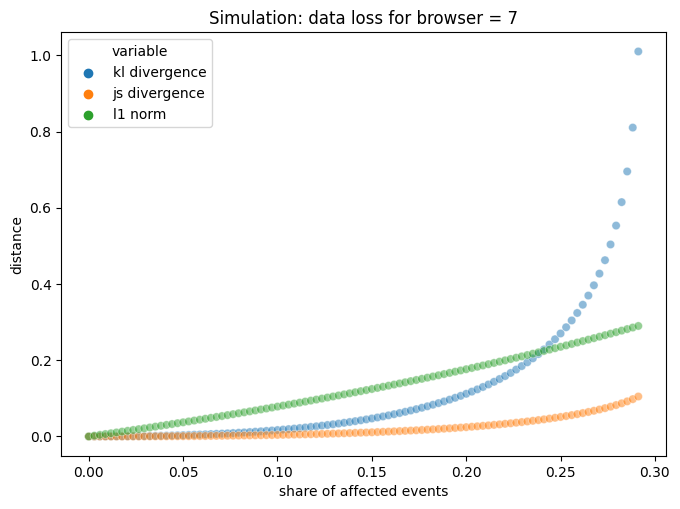

In [170]:
import seaborn as sns
from matplotlib import rcParams
rcParams['figure.figsize'] = 7.8, 5.5

def make_distances_plot(plot_df, title):
    ax = sns.scatterplot(x = 'effect_size_share', y = 'value', hue = 'variable',
             data = pd.melt(plot_df[['kl divergence', 'js divergence', 'l1 norm', 'effect_size_share']], 
                            ['effect_size_share']), alpha = 0.5)

    ax.set_xlabel('share of affected events')
    ax.set_ylabel('distance')
    ax.set_title(title)
    
make_distances_plot(data_loss_metrics_df[data_loss_metrics_df.lost_browser == 7], 
                    'Simulation: data loss for browser = 7')

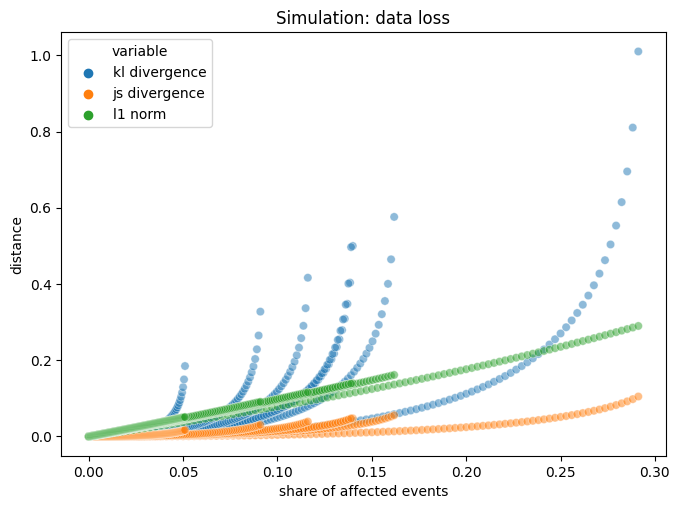

In [171]:
make_distances_plot(data_loss_metrics_df, 
                    'Simulation: data loss')

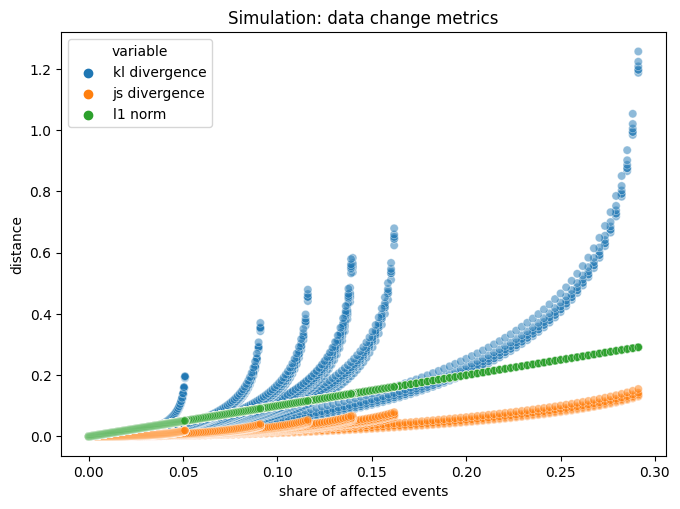

In [177]:
make_distances_plot(data_change_metrics_df, 
                    'Simulation: data change metrics')

In [172]:
data_loss_metrics_df['lost_browser_fmt'] = data_loss_metrics_df.lost_browser.map(
    lambda x: 'browser = %d' % x
)

In [173]:
def compare_metrics_by_browser(plot_df, distance, group, title):
    ax = sns.scatterplot(x = 'effect_size_share', y = distance, hue = group,
                 data = plot_df, alpha = 0.5)
    
    ax.set_xlabel('share of affected events')
    ax.set_ylabel('distance')
    ax.set_title(title)

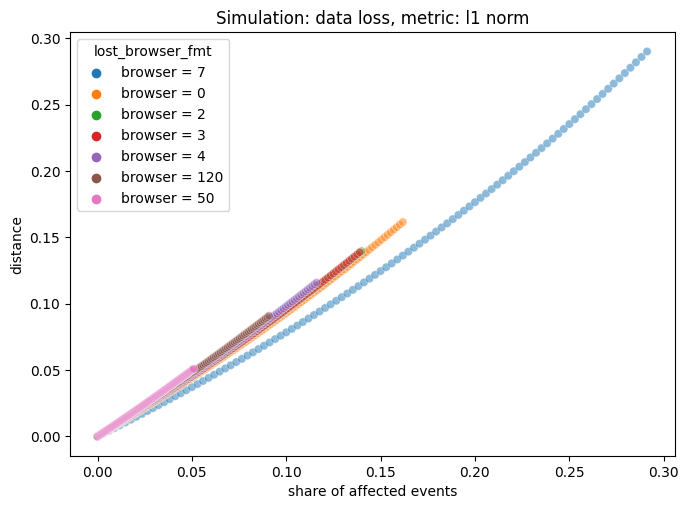

In [174]:
compare_metrics_by_browser(data_loss_metrics_df, 'l1 norm', 'lost_browser_fmt', 
                          'Simulation: data loss, metric: l1 norm')

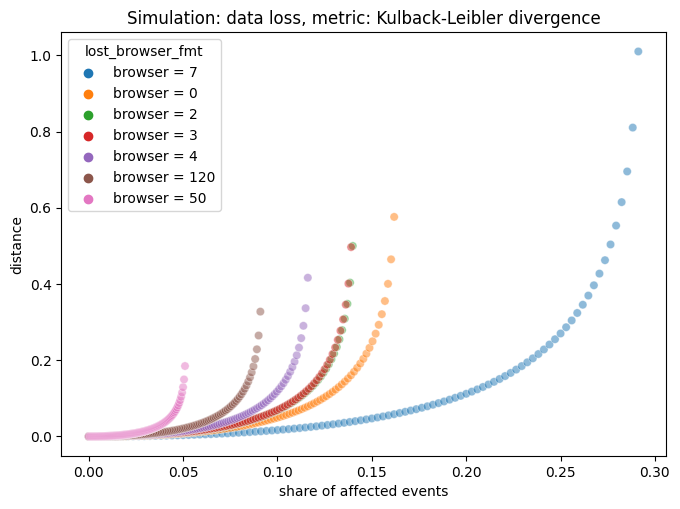

In [175]:
compare_metrics_by_browser(data_loss_metrics_df, 'kl divergence', 'lost_browser_fmt', 
                          'Simulation: data loss, metric: Kulback-Leibler divergence')

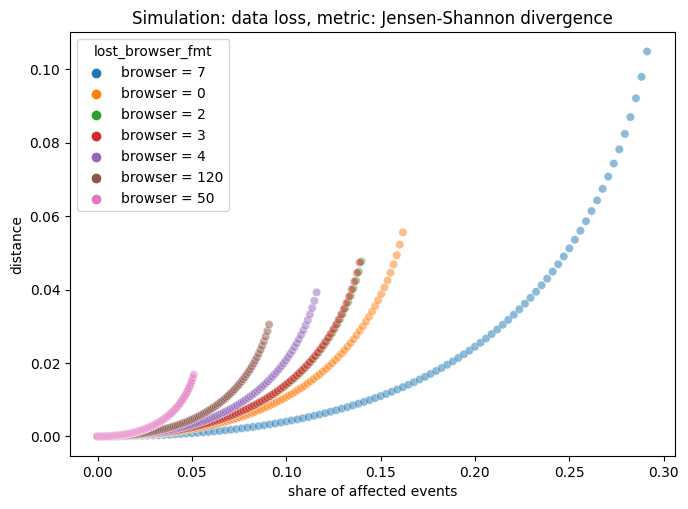

In [176]:
compare_metrics_by_browser(data_loss_metrics_df, 'js divergence', 'lost_browser_fmt', 
                          'Simulation: data loss, metric: Jensen-Shannon divergence')